# Huggingface Fine Tuning

## Overview

Step by step Hugginface fine tuning with DistilBert.

## Dependency

Using the data for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Download **jigsaw-toxic-comment-classification-challenge.zip** and place it in the directory pointed by the **DATA_DIR** variable.

## Limitations

The [save_pretrained](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.save_pretrained) method of the Huggingface Model class cannot be used on the fine-tuned model.

## References

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

* [Training TFBertForSequenceClassification with custom X and Y data](https://stackoverflow.com/a/63295240/4281353)

---
# Setups

In [248]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Constants

In [249]:
# To reduce the data volume to run through the training in short timeframe.
TEST_MODE = False
NUM_TEST_SAMPLES = 1000

# --------------------------------------------------------------------------------
## Execution recording (e.g. 2021JUL012322)
# --------------------------------------------------------------------------------
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.") 
print(f"Execution timestamp {TIMESTAMP}")

# --------------------------------------------------------------------------------
# Directory to manage the data. 
# --------------------------------------------------------------------------------
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."      # Directory where immutable files are located
BASE_DIR = "."      # Home directory of the project
OUTPUT_DIR = BASE_DIR + os.path.sep + "output"   # Directory to save mutable files.

# --------------------------------------------------------------------------------
# Data Labels that classifies the type of the comment.
# --------------------------------------------------------------------------------
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Target category
CATEGORY = "toxic"

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# --------------------------------------------------------------------------------
# HuggingFace
# --------------------------------------------------------------------------------
MAX_SEQUENCE_LENGTH = 256   # Max token length to accept. 512 taks 1 hour/epoch on Google Colab
MODEL_NAME = 'distilbert-base-uncased'

# --------------------------------------------------------------------------------
# Model
# --------------------------------------------------------------------------------
NUM_CLASSES = 1    # Number of classes/categories to classify
TARGET_LABEL_INDEX = 0 if NUM_CLASSES == 1 else 1

# Flag to freeze base model
FREEZE_BASE_MODEL = False

# Flag to add Dense(softmax) on top
USE_SOFTMAX_LAYER = True

# Flag to add custom classification layers on top of the base
USE_CLASSIFICATION_LAYER = False
if USE_CLASSIFICATION_LAYER == False:
    # Base needs to be trainable with no classification head
    FREEZE_BASE_MODEL = False

    # Base model only generates logits. Hence without classification layer
    # the base output needs to go through a Dense layer to reduce the output 
    # to NUM_CLASSES classes. It is an option not to use softmax in the last 
    # Dense layer and feed logits into the loss function.
    USE_SOFTMAX_LAYER = True

# Normalized output into the loss layer without softmax
LOGITS_TO_LOSS = False if USE_SOFTMAX_LAYER else True


Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.2021JUL10_0015
Execution timestamp 2021JUL10_0015


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [250]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [251]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/content/drive/MyDrive/home/data/kaggle/toxic_comment_classification"
    BASE_DIR = "/content/drive/MyDrive/home/repository/mon/huggingface/finetuning"
    OUTPUT_DIR = BASE_DIR + os.path.sep + "output"
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Using Google Colab environment.
Fri Jul  9 14:14:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    33W / 250W |  15849MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [252]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    OUTPUT_DIR = "/kaggle/working"


os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [253]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install -U h5py pandas matplotlib numpy 

## Modules

Install and load Python modules required for the task.

In [254]:
!pip install -q -U setuptools wheel
!pip install -q -U transformers
!pip install -q -U line_profiler memory_profiler

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.1.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.8.2)
Requirement already up-to-date: line_profiler in /usr/local/lib/python3.7/dist-packages (3.3.0)
Requirement already up-to-date: memory_profiler in /usr/local/lib/python3.7/dist-packages (0.58.0)


In [255]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [256]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Utilities


## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [257]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

## Pandas

In [258]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [259]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [260]:
import transformers
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertModel,
    # TFDistilBertForSequenceClassification,
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output Directories

In [261]:
# Result output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

RESULT_DIRECTORY = f"{OUTPUT_DIR}/run_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")

MODEL_DIRECTORY = "{parent}/model".format(
    parent=RESULT_DIRECTORY
)
Path(MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)
MODEL_FILE = MODEL_DIRECTORY + os.path.sep + "model.h5"

LOG_DIRECTORY = "{parent}/log".format(
    parent=RESULT_DIRECTORY,
)
Path(LOG_DIRECTORY).mkdir(parents=True, exist_ok=True)

---
# Data


### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [262]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

In [263]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/sample_submission.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip  
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip
  inflating: ./train.csv             
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip
  inflating: ./test.csv              
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip
  inflating: ./test_labels.csv       


## Raw Dataframes

Load the original data from the CSV files into ```raw_``` dataframes.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [264]:
raw_train = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
raw_test_label = pd.read_csv("./test_labels.csv")
raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')

if TEST_MODE:
    raw_train = raw_train.head(NUM_TEST_SAMPLES)
    raw_test = raw_test.head(NUM_TEST_SAMPLES // 2)

print(f"Counts train:{raw_train['id'].count()} test:{raw_test['id'].count()}")

Counts train:159571 test:153164


## Labels

In [265]:
# NUM_CLASSES = len(raw_train[CATEGORY].unique())
# print(f"Number lf labels = {NUM_CLASSES}")

### Raw data (train.csv)

In [266]:
# If in Google colab runtime and got an error, restart the runtime.
# "AttributeError: 'NotebookFormatter' object has no attribute 'get_result'""
# https://stackoverflow.com/questions/66412776
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [267]:
raw_train[raw_train[CATEGORY] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


### Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [268]:
raw_test[(raw_test[CATEGORY] >= 0)].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


In [269]:
def balance(
    df, 
    data_col_name,
    label_col_name,
    retain_columns,
    max_replication_ratio=sys.maxsize
):
    """Balance the data volumes of positives and negatives
    The negatives (label==0) has more volume than the positives has, hence
    causing skewed data representation. To avoid the model from adapting to the
    majority (negative), naively balance the volumes so that they have same size.

    For the ratio = (negatives / positives), replicate positives 'ratio' times 
    to match the volume of negatives if ratio < max_replication_ratio.
    When ratio > max_replication_ratio, replicate max_replication_ratio times
    to the size = (positive_size * max_replication_ratio). Then take 'size'
    volume randomly from negatives.

    A portion of the negatives will not be used because of this balancing.

    Args:
        df: Pandas dataframe 
        data_col_name: Column name for the data
        label_col_name: Column name for the label
        retain_columns: Columns to retain in the dataframe to return
    Returns: 
        Pandas dataframe with the ratin_columns.
    """
    positive_indices = df.index[df[label_col_name]==1].tolist()
    negative_indices = df.index[df[label_col_name]==0].tolist()
    assert not bool(set(positive_indices) & set(negative_indices))

    positive_size = len(positive_indices)
    negative_size = len(negative_indices)
    ratio = np.minimum(negative_size // positive_size, max_replication_ratio)

    if ratio >= 2:
        # Generate equal size of indices for positives and negatives. 
        target_positive_indices = ratio * positive_indices
        target_negative_indices = np.random.choice(
            a=negative_indices, 
            size=ratio * positive_size,
            replace=False
        ).tolist()
        indices = target_positive_indices + target_negative_indices

        # Extract [data, label] with equal size of positives and negatives
        data = df.iloc[indices][
            df.columns[df.columns.isin(retain_columns)]
        ]

    else: 
        data = df[
            df.columns[df.columns.isin(retain_columns)]
        ]
    return data

# Keep the raw non-mutated whereas train/test are mutated.
train = balance(
    df=raw_train, 
    data_col_name='comment_text', 
    label_col_name=CATEGORY,
    retain_columns=['id', 'comment_text', CATEGORY]
)
test = raw_test[(raw_test[CATEGORY] >= 0)].copy()
if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")

del raw_train, raw_test    
gc.collect()

print(f"Counts train:{train['id'].count()} test:{test['id'].count()}")

Counts train:275292 test:63978


---
# Basics for Fine Tuning 



## Tokenizer

[Tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) generates the instance of BatchEncoding which can be used as a Python dictionary and the input to the BERT model.

* [BatchEncoding](https://huggingface.co/transformers/main_classes/tokenizer.html#batchencoding)

> Holds the output of the encode_plus() and batch_encode() methods (tokens, attention_masks, etc).
> <br>
>This class is derived from a python dictionary and **can be used as a dictionary**. In addition, this class exposes utility methods to map from word/character space to token space.<br><br>
> Parameters<br>
> * data (dict) – Dictionary of lists/arrays/tensors returned by the encode/batch_encode methods (‘input_ids’, ‘attention_mask’, etc.).

The ```data``` attribute of the class is the tokens generated which has ```input_ides``` and ```attention_mask``` elements.

### input_ids

* [input_ids](https://huggingface.co/transformers/glossary.html#input-ids)

> The input ids are often the only required parameters to be passed to the model as input. They are **token indices, numerical representations of tokens** building the sequences that will be used as input by the model.

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

> 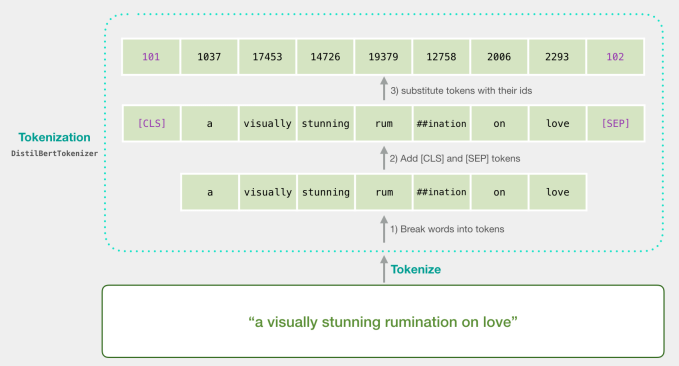


### attention_mask

* [Attention mask](https://huggingface.co/transformers/glossary.html#attention-mask)

> This argument indicates to the model which tokens should be attended to, and which should not.

If the attention_mask is ```0```, the token id is ignored. For instance if a sequence is padded to adjust the sequence length, the padded words should be ignored hence its attention_mask is 0.


In [1]:
    tokenizer = DistilBertTokenizerFast.from_pretrained(
        'distilbert-base-uncased',
        do_lower_case=True
    )


    def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
        """Tokenize using the Huggingface tokenizer
        Args: 
            sentences: String or list of string to tokenize
            max_length: maximum token length that the tokenizer generates
            padding: Padding method ['do_not_pad'|'longest'|'max_length']
        """
        return tokenizer(
            sentences,
            truncation=True,
            padding=padding,
            max_length=max_length,
            return_tensors="tf"
        )

def decode(tokens):
    """Decode token ids back to string sequence
    Args:
        tokens: output of the tokenizer having the structure:
                {'input_ids': <tf.Tensor>, 'attention_mask': <tf.Tensor>}
    Returns: List of string sentence
    """
    sentences = []
    for sequence in tokens['input_ids']:
        sentences.append(tokenizer.decode(sequence.numpy().tolist()))

    return sentences

SyntaxError: invalid syntax (3802015492.py, line 3)

When tokenized, ```i say hello``` (length 3) is padded with a special token ```[PAD]``` to match ```you say good bye``` (length 4). Hence the ```atttention_mask``` for ```i say hello``` has ```0``` at the end as in ```[1, 1, 1, 1, 1, 0]```.

In [271]:
sample_tokens = tokenize(
    [   # Two example seenteces
        "i say hello", 
        "you say good bye",
    ],
    padding='longest'
)
print(f"generatred {type(sample_tokens)} with content:\n{sample_tokens}")

generatred <class 'transformers.tokenization_utils_base.BatchEncoding'> with content:
{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 1045, 2360, 7592,  102,    0],
       [ 101, 2017, 2360, 2204, 9061,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [272]:
for sequence in sample_tokens['input_ids']:
    print(decode(sequence))

[CLS] i say hello [SEP] [PAD]
[CLS] you say good bye [SEP]


### Special Tokens

[BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) addes special tokens, hence enclose dwith ```[CLS]``` and ```[SEP]```. Espacially beware of the ```[CLS]``` that represents **Classification**. ```[SEP]``` token seprates each sequence. For Question Answer or Paraphrase tasks, ```[SEP]``` seprates the two sentences to compare.

* cls_token (str, optional, defaults to "**[CLS]**")<BR>The **Classifier Token which is used when doing sequence classification** (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.
* sep_token (str, optional, defaults to "[SEP]")<BR>The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
* unk_token (str, optional, defaults to "[UNK]")<BR>The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this token instead.
* pad_token (str, optional, defaults to "[PAD]")<BR>The token used for padding, for example when batching sequences of different lengths.
* mask_token (str, optional, defaults to "[MASK]")<BR>The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.

## Base Model - TFDistilBertModel

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

> TFDistilBertModel class to instantiate the base DistilBERT model **without any specific head on top** (as opposed to other classes such as TFDistilBertForSequenceClassification that do have an added classification head). <br><br>
We do not want any task-specific head attached because we simply want the pre-trained weights of the base model to provide a general understanding of the English language, and it will be our job to add our own classification head during the fine-tuning process in order to help the model distinguish between toxic comments.

* HuggingFace Document [TFDistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel)

```
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state
```



Note that the ```num_labels``` parameter has no effect on the base model as the base model only generates logits, not classifications. You need to have a Dense layer on top to reduce the ```[CLS]``` embedding part of the logits into NUM_CLASSES classes for your classification tasks.

In [273]:
# Use TFDistilBertModel as TFDistilBertForSequenceClassification has classification heads added.
# base = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
base = TFDistilBertModel.from_pretrained(
    MODEL_NAME,
    # num_labels=NUM_CLASSES    # no effect
)

# Freeze the base model weights.
if FREEZE_BASE_MODEL:
    for layer in base.layers:
        layer.trainable = False

base.summary()

Model: "tf_distil_bert_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [274]:
# Cannot get the output_shape of the pretrained model with the error.
# AttributeError: The layer has never been called and thus has no defined output shape.
# https://stackoverflow.com/questions/68234881
#for layer in base.layers:
#    print(layer.output_shape)

## Output of TFDistilBertModel

```TFDistilBertModel``` generates an instance of ```TFBaseModelOutput``` whose ```last_hidden_state``` parameter is the output from the model last layer. The image in the cell downwards has the detail.

```
TFBaseModelOutput([(
    'last_hidden_state',
    <tf.Tensor: shape=(batch_size, sequence_lendgth, 768), dtype=float32, numpy=array([[[...]]], dtype=float32)>
)])
```
* [TFBaseModelOutput](https://huggingface.co/transformers/main_classes/output.html#tfbasemodeloutput)

> Parameters<br>
> * last_hidden_state (tf.Tensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the output of the last layer of the model.


In [275]:
base_model_output = base(sample_tokens)
#tf.print(base_model_output, summarize=1)
print(base_model_output)

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.08046165, -0.0507057 ,  0.16511469, ...,  0.02624888,
          0.32072198,  0.29028502],
        [ 0.38065857,  0.14633183,  0.3267995 , ..., -0.03747691,
          0.6750764 ,  0.2675419 ],
        [-0.13755916,  0.23116165,  0.9399945 , ..., -0.4190009 ,
          0.03066512,  0.14690885],
        [-0.46870425, -0.15961106,  0.706487  , ...,  0.09092121,
          0.00915727, -0.02296945],
        [ 0.9486712 ,  0.28354228, -0.34940293, ...,  0.22489347,
         -0.41922653, -0.44231758],
        [ 0.11706695,  0.02730663,  0.36414492, ...,  0.22984342,
          0.05139092,  0.08807844]],

       [[-0.13671064, -0.07976629,  0.13336916, ..., -0.09188624,
          0.18120876,  0.14311405],
        [-0.18604988,  0.00228974,  0.8748206 , ...,  0.25758234,
          0.5174809 ,  0.07797474],
        [ 0.04087265,  0.11673994,  1.1603651 , ..., -0.40428668,
          0.04986678,  0.20

The numerical matrix of the output can be acquired with ```last_hidden_state``` property or the indexing ```[0]``` as the root class ModelOutput provides ```__getitems``` method for indexing.

* [ModelOutput](https://huggingface.co/transformers/main_classes/output.html#modeloutput) 
> Base class for all model outputs as dataclass. Has a __getitem__ that allows indexing by integer or slice (like a tuple) or strings (like a dictionary) that will ignore the None attributes. Otherwise behaves like a regular python dictionary.

In [276]:
print(base_model_output.last_hidden_state)

tf.Tensor(
[[[-0.08046165 -0.0507057   0.16511469 ...  0.02624888  0.32072198
    0.29028502]
  [ 0.38065857  0.14633183  0.3267995  ... -0.03747691  0.6750764
    0.2675419 ]
  [-0.13755916  0.23116165  0.9399945  ... -0.4190009   0.03066512
    0.14690885]
  [-0.46870425 -0.15961106  0.706487   ...  0.09092121  0.00915727
   -0.02296945]
  [ 0.9486712   0.28354228 -0.34940293 ...  0.22489347 -0.41922653
   -0.44231758]
  [ 0.11706695  0.02730663  0.36414492 ...  0.22984342  0.05139092
    0.08807844]]

 [[-0.13671064 -0.07976629  0.13336916 ... -0.09188624  0.18120876
    0.14311405]
  [-0.18604988  0.00228974  0.8748206  ...  0.25758234  0.5174809
    0.07797474]
  [ 0.04087265  0.11673994  1.1603651  ... -0.40428668  0.04986678
    0.20140114]
  [ 0.4905054   0.17764185  1.6637994  ... -0.26952428 -0.14997017
   -0.04277818]
  [ 0.90368366 -0.19236276  1.062132   ...  0.18384317 -0.45228904
    0.02702057]
  [ 0.9119451   0.19694906 -0.34033245 ...  0.13686879 -0.48537374
   -0.411

In [277]:
print(base_model_output[0])

tf.Tensor(
[[[-0.08046165 -0.0507057   0.16511469 ...  0.02624888  0.32072198
    0.29028502]
  [ 0.38065857  0.14633183  0.3267995  ... -0.03747691  0.6750764
    0.2675419 ]
  [-0.13755916  0.23116165  0.9399945  ... -0.4190009   0.03066512
    0.14690885]
  [-0.46870425 -0.15961106  0.706487   ...  0.09092121  0.00915727
   -0.02296945]
  [ 0.9486712   0.28354228 -0.34940293 ...  0.22489347 -0.41922653
   -0.44231758]
  [ 0.11706695  0.02730663  0.36414492 ...  0.22984342  0.05139092
    0.08807844]]

 [[-0.13671064 -0.07976629  0.13336916 ... -0.09188624  0.18120876
    0.14311405]
  [-0.18604988  0.00228974  0.8748206  ...  0.25758234  0.5174809
    0.07797474]
  [ 0.04087265  0.11673994  1.1603651  ... -0.40428668  0.04986678
    0.20140114]
  [ 0.4905054   0.17764185  1.6637994  ... -0.26952428 -0.14997017
   -0.04277818]
  [ 0.90368366 -0.19236276  1.062132   ...  0.18384317 -0.45228904
    0.02702057]
  [ 0.9119451   0.19694906 -0.34033245 ...  0.13686879 -0.48537374
   -0.411

### Shape
In the model ```distilbert-base-uncased```, each token is embedded into a vector of size **768**. 
```(batch_size, max_sequence_length, embedding_vector_size=768)```. According to the originan paper, the BERT/BASE model (as indicated in distilbert-***base***-uncased) has the embedding vector size 768 and the 12 layers to be compatible with OpenAI GPT for comparison.

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

> BERT/BASE (L=12, H=768, A=12, Total Parameters=110M) and BERT/LARGE (L=24, H=1024, A=16, Total Parameters=340M).



In [278]:
NUM_BASE_MODEL_OUTPUT = base_model_output.last_hidden_state.shape[-1]
print("Base model last layer ouptput shape:(batch_size, sequence_length, num_output)={}".format(
    base_model_output.last_hidden_state.shape
))
print(f"Number of output (number of neurons) in the base model last layer {NUM_BASE_MODEL_OUTPUT}")

Base model last layer ouptput shape:(batch_size, sequence_length, num_output)=(2, 6, 768)
Number of output (number of neurons) in the base model last layer 768


##  [CLS]

The embedding vector for **```[CLS]```** in the output from the base model final layer represents the classification that has been learned by the base model. Hence feed the embedding vector for **```[CLS]```** token into the classifiation head that you add on top of the base model. 

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

> The first token of every sequence is always ```a special classification token ([CLS])```. The final hidden state corresponding to this token is **used as the aggregate sequence representation for classification tasks**. Sentence pairs are packed together into a single sequence. We differentiate the sentences in two ways. First, we separate them with a special token ([SEP]). Second, we add a learned embedding to every token indicating whether it belongs to sentence A or sentence B.

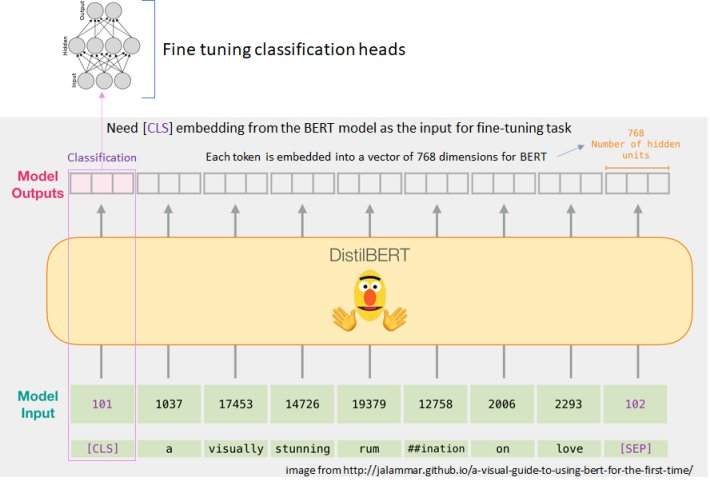


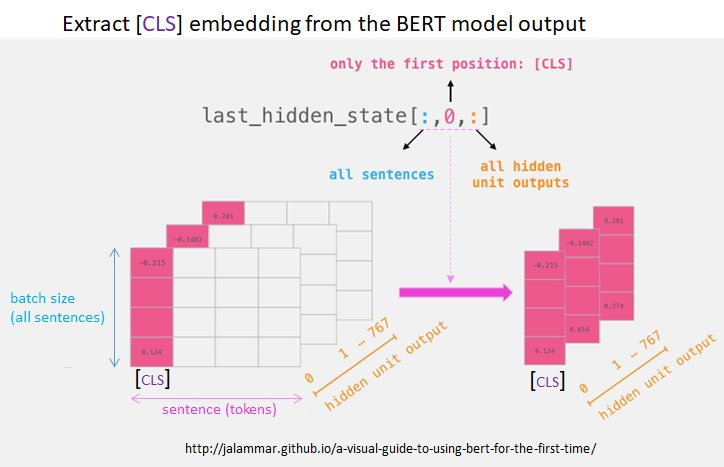


---
# Fine Tuning Approach

There are multiple approaches to fine-tune BERT for the target tasks.

1. Further Pre-training the base BERT model
2. Custom classification heads with the base BERT model trainable
3. Custom classification heads with the base BERT model non-trainable (frozen)

Note that the BERT base model has not been pre-trained for sequence classification tasks as in the original paper.
> 
> 3.1 Pre-training BERT ...we pre-train BERT using two unsupervised tasks<br>
> * Task #1: Masked LM<br>
> * Task #2: Next Sentence Prediction (NSP)<br>

Hence the base BERT model can be regarded as half-baked material which can be fully baked for your target domain (1st method). We also can use it as part of our own custom model setting with the base trainable (2nd method), or not-trainable (3rd method).

## Further Pre-training

The paper [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/abs/1905.05583) has demostranted the 1st way.

> 4.2 Further Pre-training<br>The BERT model is pre-trained in the generaldomain corpus. For a text classification task in a specific domain, such as movie reviews, its data
distribution may be different from BERT. Therefore, we can further pre-train BERT with masked language model and next sentence prediction tasks on the domain-specific data. Three further pretraining approaches are performed:<br>
1. Within-task pre-training, in which BERT is
further pre-trained on the training data of a target
task.<br>
2. In-domain pre-training, in which the pretraining data is obtained from the same domain of a target task. For example, there are several different sentiment classification tasks, which have a similar data distribution. We can further pre-train BERT on the combined training data from these tasks.<br>
3. Cross-domain pre-training, in which the pretraining data is obtained from both the same and other different domains to a target task. We will investigate these different approaches to further pre-training in Sec. 5.4.

### Learning Rate

The papaer pointed out that the learning rate must be carefully selected to avoid **Catastrophic Forgetting** where the pre-trained knowledge is erased during learning of new knowledge.

> We find that a lower learning rate, such as 2e-5,
is necessary to make BERT overcome the catastrophic forgetting problem. With an aggressive learn rate of 4e-4, the training set fails to converge.

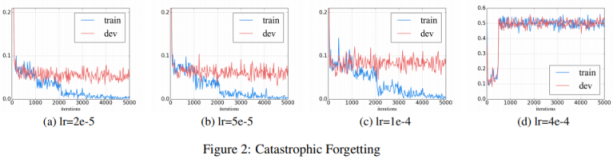

Probably this is the reason wht the original BERT paper used 5e-5, 4e-5, 3e-5, and 2e-5.

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

> We use a batch size of 32 and fine-tune for 3 epochs over the data for all GLUE tasks. For each task, we selected the best fine-tuning learning rate (among 5e-5, 4e-5, 3e-5, and 2e-5) on the Dev set




## Huggingface

Huggingface takes the 2nd approach as in [Fine-tuning with native PyTorch/TensorFlow](https://huggingface.co/transformers/custom_datasets.html#fine-tuning-with-native-pytorch-tensorflow) where ```TFDistilBertForSequenceClassification``` provides the custom classification head ```classifier``` on top of the base ```distilbert``` model.

```
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss) # can also use any keras loss fn
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16)
```


---
# Fine Tuning Model (3rd way)

Implement the model in the 3rd way.

In [279]:
test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

## Hyper Parameters

In [280]:
# Model training
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-2 if FREEZE_BASE_MODEL else 5e-5
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

### Input layer

The base model expects ```input_ids``` and ```attention_mask``` whose shape is ```(max_sequence_length,)```. Generate Keras Tensors for them with ```Input``` layer respectively and generate the output from the base model. The base model generates ```TFBaseModelOutput```. Feed the embedding of **```[CLS]```** to the next layer.

In [281]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

### Base layer

In [282]:
# TFBaseModelOutput.last_hidden_state has shape (batch_size, max_sequence_length, 768)
# Each sequence has [CLS]...[SEP] structure of shape (max_sequence_length, 768)
# Extract [CLS] embeddings of shape (batch_size, 768) as last_hidden_state[:, 0, :]
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

### Classification layers

In [283]:
if USE_CLASSIFICATION_LAYER:
    # -------------------------------------------------------------------------------
    # Classifiation leayer 01
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dropout(
        rate=0.15,
        name="01_dropout",
    )(output)
    
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="01_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="01_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="01_relu"
    )(output)

    # --------------------------------------------------------------------------------
    # Classifiation leayer 02
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="02_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="02_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="02_relu"
    )(output)

### Output Normalization Layer


In [284]:
# --------------------------------------------------------------------------------
# TODO:
#    Need to verify the effect of regularizers. 
#
#    [bias regularizer]
#    It looks bias_regularizer adjusts the ROC threshold towards 0.5. 
#    Without it, the threshold of the ROC with BinaryCrossEntropy loss was approx 0.02.
#    With    it, the threshold of the ROC with BinaryCrossEntropy loss was approx 0.6.
# --------------------------------------------------------------------------------
activation = "sigmoid" if NUM_CLASSES == 1 else "softmax"
if USE_SOFTMAX_LAYER:
    LIGITS_TO_LOSS = False
    output = tf.keras.layers.Dense(
        units=NUM_CLASSES,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
        bias_regularizer=tf.keras.regularizers.l2(l2=L2),
        # activity_regularizer=tf.keras.regularizers.l2(l2=L2/10.0),
        activation=activation,
        name=activation
    )(output)

### Keras Model

In [285]:
name = f"{TIMESTAMP}_{MODEL_NAME.upper()}"
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name=name)

if NUM_CLASSES == 1:
    METRIC_NAME = "auc"
    MONITOR_METRIC = f"val_{METRIC_NAME}"
    MONITOR_MODE = 'max'
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=LIGITS_TO_LOSS)
    metrics=[tf.keras.metrics.AUC(from_logits=LIGITS_TO_LOSS, name=METRIC_NAME), "accuracy"]
else:
    METRIC_NAME = "accuracy"
    MONITOR_METRIC = "val_loss"
    MONITOR_MODE = 'min'
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=LIGITS_TO_LOSS)
    # metrics=[tf.keras.metrics.Accuracy(name=METRIC_NAME)]
    metrics=["accuracy"]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=loss_fn,
    metrics=metrics
)
model.summary()

Model: "2021JUL10_0015_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_5 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 768)          0       

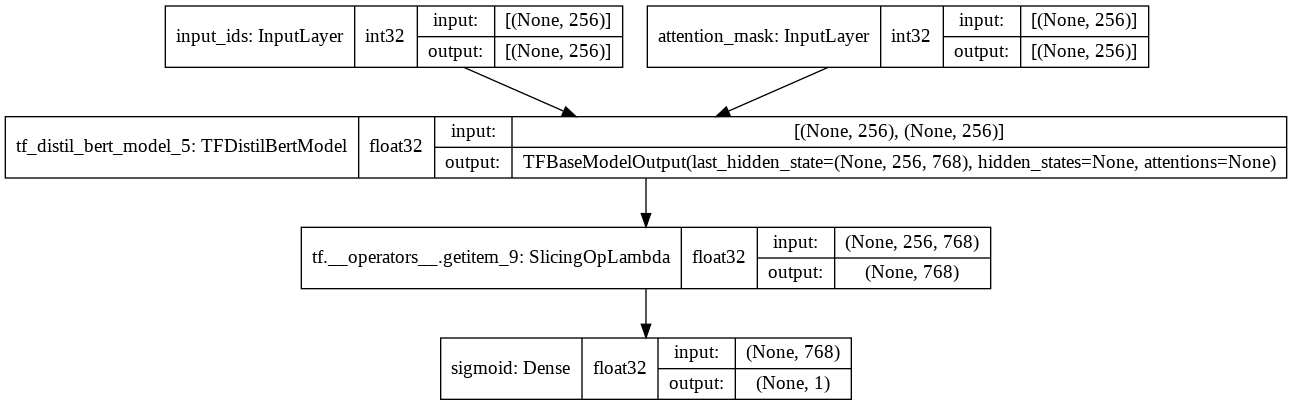

In [286]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

### Model Utilities

In [287]:
def generate_target_predictions(num_classes, index):
    """Extract predictions for the label at the index position.
    With N labels/classes e.g 0, 1, 2 and predictions are [[0.3, 0.2, 0.5]]
    predictions_for_label(3, 1) to extract the prediction '0.2' for the label at index '1'

    For binary classification with sigmoid where num_classes==1, extract [:, 0]
    For binary classification with softmax where num_classes==2, extract [:, 1]

    Args:
        predictions: Tensor or Numpy array of shape (batch_size, num_classes)
        num_classes: Number of labels.
        index: Index of the target predictions.
    Returns: numpy 1D array of predictions at the index [:, index]
    """
    assert 0 <= index < num_classes
    assert index == 0 if num_classes == 1 else ...
    def f(predictions):
        if tf.is_tensor(predictions):
            predictions = predictions.numpy()
        elif isinstance(predictions, np.ndarray):
            pass
        else:
            raise RuntimeError(f"Unexpected prediction type {type(predictions)}")
        
        assert predictions.shape[-1] == num_classes, \
            f"Expected shape is (batch_size, {num_classes}). Got {predictions.shape}"
        
        return predictions[:, index]
        
    return f


get_target_predictions = generate_target_predictions(num_classes=NUM_CLASSES, index=TARGET_LABEL_INDEX)
def predict(model, tokens):
    return get_target_predictions(model.predict(dict(tokens)))


import sklearn.metrics
def evaluate_roc(predictions, labels, title):
    preds = predictions
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, preds)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    # print(f'AUC: {roc_auc:.4f}')

    threshold = thresholds[np.argmax(tpr - fpr)]
    # print(f'Threshold: {threshold:.5f}')
    
    # Get accuracy over the test set
    y_pred = np.where(preds >= threshold, 1, 0)
    accuracy = sklearn.metrics.accuracy_score(labels, y_pred)
    # print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plot ROC AUC
    plt.figure(figsize=(6, 4))
    plt.title(f'{title}')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.grid(which='major', b=False, linestyle='--')
    plt.grid(which='minor', alpha=0.2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # --------------------------------------------------------------------------------
    # Optimal Threshold
    # --------------------------------------------------------------------------------
    return roc_auc, accuracy, threshold

### Model validations

In [288]:
test_model_output = model(test_tokens)
test_predictions = predict(model, test_tokens)
assert test_model_output.shape == (TEST_BATCH_SIZE, NUM_CLASSES)
assert test_predictions.shape == (TEST_BATCH_SIZE,)
assert np.all(0 < test_predictions) and np.all(test_predictions < 1)

---
# Training

### Keras Callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [289]:
from sklearn.metrics import roc_auc_score
from keras import backend


class ROCCallback(tf.keras.callbacks.Callback):
    """calculate ROC&AUC
    """
    def __init__(
        self, 
        validation_data, 
        validation_label, 
        output_path, 
        reduce_lr_patiene = 3,
        reduce_lr_factor = 0.2,
        early_stop_patience=sys.maxsize, 
        verbose=True
    ):
        assert 0.0 < reduce_lr_factor < 1.0
        assert 0 < reduce_lr_patiene
        assert 0 < early_stop_patience        

        self.x = validation_data
        self.y = validation_label
        self.output_path = output_path
        self.reduce_lr_patiene = reduce_lr_patiene
        self.reduce_lr_factor = reduce_lr_factor
        self.early_stop_patience = early_stop_patience
        self.verbose = verbose    

        self.max_value = 0
        self.best_epoch = -1
        self.successive_no_improvement = 0
        self.total_no_improvement = 0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def _reduce_learning_rate(self):
        old_lr = backend.get_value(self.model.optimizer.lr)
        new_lr = old_lr * self.reduce_lr_factor
        backend.set_value(self.model.optimizer.lr, new_lr)
        self.successive_no_improvement = 0
        if self.verbose:
            print(f"Reducing learning rate to {new_lr}.")
            
    def _early_stop(self):
        self.model.stop_training = True
        self.total_no_improvement = 0
        if self.verbose:
            print(
                "Early stopping: total no improvement [%s] times. best epoch [%s] AUC [%s]" % 
                (self.total_no_improvement, self.best_epoch, self.max_value)
            )
            
    def on_epoch_end(self, epoch, logs={}):
        # [print(f"{k}:{v}") for k, v in logs.items()]
        predictions = self.model.predict(self.x)
        score = roc_auc_score(self.y, predictions)

        if (self.best_epoch < 0) or (score > self.max_value):
            # --------------------------------------------------------------------------------
            # Save the model upon improvement
            # --------------------------------------------------------------------------------
            if self.verbose:
                print(f"Model auc improved [{score} > {self.max_value:0.5f}]: Saving to {self.output_path}")

            self.max_value = score
            self.best_epoch = epoch
            self.model.save_weights(
                self.output_path, overwrite=True, save_format='h5'
            )

            # Reset counters
            self.successive_no_improvement = 0
            
            # The AUC can not improve than 1.0. Early stop.
            if score > (1.0 - 1e-10):
                self._early_stop()

        else:
            print(f"AUC did not improve from [{self.max_value:0.5f}].")
            # --------------------------------------------------------------------------------
            # Reduce LR
            # --------------------------------------------------------------------------------
            self.successive_no_improvement += 1
            if self.successive_no_improvement >= self.reduce_lr_patiene:
                self._reduce_learning_rate()
                
            # --------------------------------------------------------------------------------
            # Early Stop
            # --------------------------------------------------------------------------------
            self.total_no_improvement += 1
            if self.total_no_improvement >= self.early_stop_patience:
                self._early_stop()
        
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.
    
    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    
    """
    def __init__(self, output_dir, monitor='val_loss', mode='auto', verbose=True):
        super().__init__()
        self.output_dir = output_dir
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose

        self.lowest_val_loss=np.inf
        self.best_epoch = -1
        
    def on_epoch_end(self, epoch, logs={}):
        """
        Save only the best model
        - https://stackoverflow.com/a/68042600/4281353
        - https://www.tensorflow.org/guide/keras/custom_callback
        
        TODO: 
        save_pretrained() method is in the HuggingFace model only.
        Need to implement an logic to update for Keras model saving.
        """
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        
        val_loss=logs.get(monitor)
        if (self.best_epoch < 0) or (val_loss < self.lowest_val_loss):
            if self.verbose:
                print(f"Model val_loss improved: [{val_loss} < {self.lowest_val_loss}]")
                print(f"Saving to {self.output_dir}")
            self.lowest_val_loss = val_loss
            self.best_epoch = epoch
            self.model.save_pretrained(self.output_dir)


class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3, monitor='val_loss', mode='auto'):
        assert patience > 0
        super().__init__(
            monitor=monitor, 
            mode=mode, 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)


class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: 
        Did not work with the HuggingFace native model with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable.
        
        Did not work with the tf.keras.models.save_model nor model.save()
        as causing out-of-index errors or load_model() failures. Hence use
        save_weights_only=True.
    """
    def __init__(self, path_to_file, monitor='val_loss', mode='auto'):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor=monitor, 
            mode=mode, 
            save_best_only=True,
            save_weights_only=True,  # Cannot save entire model.
            save_freq="epoch",
            verbose=1
        )

    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)
        

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3, monitor='val_loss', mode='auto'):
        assert patience > 0
        super().__init__(
            monitor=monitor, 
            mode=mode, 
            factor=0.2,
            patience=patience,
            verbose=1
        )
    def on_epoch_end(self, epoch, logs={}):
        assert self.monitor in logs, \
            f"monitor metric {self.monitor} not in valid metrics {logs.keys()}"
        super().on_epoch_end(epoch, logs)


## Data Allocation


In [290]:
# --------------------------------------------------------------------------------
# Split data into training and validation
# --------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(
    train['comment_text'].tolist(),
    train[CATEGORY].tolist(),
    test_size=.2,
    shuffle=True
)

In [291]:
# Convert BatchEncoding to dictionary mapping to TF Tensor. 
# X = dict(tokenize(train_data))
# Y = tf.convert_to_tensor(train_label)
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(train_data)),  # Convert BatchEncoding instance to dictionary
    train_label
)).batch(BATCH_SIZE).prefetch(1)

In [292]:
VT = dict(tokenize(validation_data))  # Convert BatchEncoding instance to dictionary
V = tf.data.Dataset.from_tensor_slices((
    VT,  
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

## Run

In [293]:
print("""
TEST_MODE= {}
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
L2 = {}
MONITOR_METRIC = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    TEST_MODE,
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    L2,
    MONITOR_METRIC,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY,
))


TEST_MODE= False
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 5e-05
L2 = 0.001
MONITOR_METRIC = val_auc
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL10_0015/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL10_0015/log



In [294]:
# Load the saved model if exists
if os.path.isfile(MODEL_FILE):
    print(f"loading the saved model parameters from {MODEL_FILE}")
    model.load_weights(MODEL_FILE)

In [295]:
# --------------------------------------------------------------------------------
# Train the model
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# Input data x can be a dict mapping input names to the corresponding array/tensors, 
# if the model has named inputs. Beware of the "names". y should be consistent with x 
# (you cannot have Numpy inputs and tensor targets, or inversely). 
# --------------------------------------------------------------------------------
history = model.fit(
    x=X,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=V,
    callbacks=[
        # EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        #ReduceLRCallback(patience=REDUCE_LR_PATIENCE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        # ModelCheckpointCallback(MODEL_FILE, monitor=MONITOR_METRIC, mode=MONITOR_MODE),
        ROCCallback(
            validation_data=VT, 
            validation_label=validation_label, 
            output_path=MODEL_FILE, 
            reduce_lr_patiene = REDUCE_LR_PATIENCE,
            reduce_lr_factor = 0.2,
            early_stop_patience=EARLY_STOP_PATIENCE, 
            verbose=True
        ),
        #TensorBoardCallback(LOG_DIRECTORY)
    ]
)

Epoch 1/5
6883/6883 [==============================] - 3556s 516ms/step - loss: 0.1037 - auc: 0.9923 - accuracy: 0.9631 - val_loss: 0.0580 - val_auc: 0.9969 - val_accuracy: 0.9814
Model auc improved [0.9971094884339834 > 0.00000]: Saving to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL10_0015/model/model.h5
Epoch 2/5
6883/6883 [==============================] - 3548s 516ms/step - loss: 0.0375 - auc: 0.9981 - accuracy: 0.9891 - val_loss: 0.0374 - val_auc: 0.9975 - val_accuracy: 0.9898
Model auc improved [0.9981901120082238 > 0.99711]: Saving to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL10_0015/model/model.h5
Epoch 3/5
6883/6883 [==============================] - 3551s 516ms/step - loss: 0.0207 - auc: 0.9990 - accuracy: 0.9943 - val_loss: 0.0433 - val_auc: 0.9964 - val_accuracy: 0.9903
AUC did not improve from [0.99819].
Reducing learning rate to 9.999999747378752e-06.
Epoch 4/5
6883/6883 [==================

## Save Model

Due to the issues, ```model.save_weights``` is the only way as of now. ModelCheckpoint requiring ```save_weights_only=False```.

save_format='h5' requires a file path but save_format='tf' requires a directory.


### Issues

* [tf.keras.models.save_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)

Default save_traces=True causes IndexError: list index out of range
save_format='h5' causes NotYetImplementedException 

'''tf.keras.models.save_model(model, MODEL_DIRECTORY, save_format='tf', save_traces=False)''' causes the error below at ```tf.keras.models.load_model(MODEL_DIRECTORY)```.

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-71-01d66991d115> in <module>()
----> 1 tf.keras.models.load_model(MODEL_DIRECTORY)

11 frames
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/saving/saved_model/load.py in _unable_to_call_layer_due_to_serialization_issue(layer, *unused_args, **unused_kwargs)
    865       'recorded when the object is called, and used when saving. To manually '
    866       'specify the input shape/dtype, decorate the call function with '
--> 867       '`@tf.function(input_signature=...)`.'.format(layer.name, type(layer)))
    868 
    869 

ValueError: Cannot call custom layer tf_distil_bert_model of type <class 'tensorflow.python.keras.saving.saved_model.load.TFDistilBertModel'>, because the call function was not serialized to the SavedModel.Please try one of the following methods to fix this issue:

(1) Implement `get_config` and `from_config` in the layer/model class, and pass the object to the `custom_objects` argument when loading the model. For more details, see: https://www.tensorflow.org/guide/keras/save_and_serialize

(2) Ensure that the subclassed model or layer overwrites `call` and not `__call__`. The input shape and dtype will be automatically recorded when the object is called, and used when saving. To manually specify the input shape/dtype, decorate the call function with `@tf.function(input_signature=...)`.
```

In [296]:
# DO NOT save as it will overwrite the best model saved during the training.
# model.save_weights(
#    MODEL_FILE, overwrite=True, save_format='h5'
# )

---
# Evaluation

## Load the best model saved during the training

In [ ]:
model.load_weights(filepath)

In [297]:
tokens = dict(tokenize(test['comment_text'].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((
    tokens,
    test[CATEGORY]
))
evaluation = model.evaluate(
    test_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(1)
)
print(f"evaluation({model.metrics_names})={evaluation}")

2000/2000 [==============================] - 332s 165ms/step - loss: 0.6387 - auc: 0.9238 - accuracy: 0.9153
evaluation(['loss', 'auc', 'accuracy'])=[0.6386972665786743, 0.9237757921218872, 0.9153146147727966]


## ROC

In [298]:
probabilities = predict(model, tokens)

AUC: 0.9458
Accuracy: 91.53%


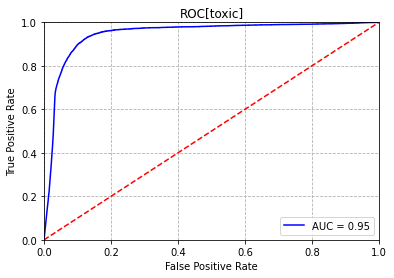

0.0020384202


In [299]:
roc_auc, accuracy, threshold = evaluate_roc(probabilities, test[CATEGORY], f"ROC[{CATEGORY}]")
print(threshold)

## Recall

In [300]:
# predictions = np.argmax(model.predict(tokens), axis=-1)
predictions = np.reshape(probabilities >= threshold, (-1, 1)).astype(int)
test['prediction'] = predictions
test.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,prediction
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,False
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,True
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0,True


In [301]:
print(f"Threshold[{CATEGORY}] {threshold}")

# NP: Negative Predictions
# PP: Positive Predictions
PP = test[(test['prediction'] > threshold)]['id'].count()
NP = test[(test['prediction'] <= threshold)]['id'].count()
ALL = PP + NP

# TP: True Positive Prediction
# AP: Actual Positive
# TN: True Negative Prediction
# AN: Actual Negative
TP = test[(test[CATEGORY] == 1) & (test['prediction'] > threshold)]['id'].count()
AP = test[(test[CATEGORY] == 1)]['id'].count()
TN = test[(test[CATEGORY] == 0) & (test['prediction'] <= threshold)]['id'].count()
AN = test[(test[CATEGORY] == 0)]['id'].count()

print(f"[{CATEGORY:13s}] TP {TP/ALL:0.3f} FP {(PP-TP)/ALL:0.3f} TN: {TN/ALL:0.3f} FN {(NP-TN)/ALL:0.3f}" ) 
if AP > 0:
    print(f"[{CATEGORY:13s}] True Positive Rate (Recall) : {TP/AP:0.3f}" ) 
if PP > 0:
    print(f"[{CATEGORY:13s}] Positive Precision          : {TP/PP:0.3f}" ) 
if AN > 0:
    print(f"[{CATEGORY:13s}] True Negative Rate (Recall) : {TN/AN:0.3f}") 
if NP > 0:
    print(f"[{CATEGORY:13s}] Negative Precision          : {TN/NP:0.3f}" ) 
if True:
    print(f"[{CATEGORY:13s}] Accuracy                    : {(TP+TN)/ALL:0.3f}" ) 

TP 0.089 FP 0.115 TN: 0.789 FN 0.007
Positive/toxic     : Recall 0.930
Negative/non-toxic : Recall 0.873



---
# Results